<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/coo_to_midpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import nan, linspace, min, max, reshape, mean, int64, float64, random, std, arange
from pandas import DataFrame, read_csv, concat
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from scipy.stats import norm, shapiro
from math import sqrt
from gc import collect
from joblib import dump
from IPython.display import clear_output
clear_output()

In [ ]:
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep pandas_profiling
!pip list | grep matplotlib
!pip list | grep plotly
!pip list | grep catboost
!pip list | grep scikit-learn
!pip list | grep scipy
!pip list | grep joblib
!pip list | grep ipython

numpy                         1.18.5         
pandas                        1.0.5          
pandas-datareader             0.8.1          
pandas-gbq                    0.11.0         
pandas-profiling              2.8.0          
sklearn-pandas                1.8.0          
matplotlib                    3.2.2          
matplotlib-venn               0.11.5         
plotly                        4.4.1          
catboost                      0.24           
scikit-learn                  0.22.2.post1   
scipy                         1.4.1          
joblib                        0.16.0         
ipython                       5.5.0          
ipython-genutils              0.2.0          
ipython-sql                   0.3.9          


In [ ]:
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_pha_thousand.csv',
              
              dtype={'X1': 'int64',
                     'Y1': 'int64',
                     'X2': 'int64',
                     'Y2': 'int64',
                     'MID_POINT_X': 'float64',
                     'MID_POINT_Y': 'float64',
                     'Area': 'int64',
                     'long': 'float64',
                     'lat': 'float64',
                     'Long_minus': 'int64',
                     'Lat_minus': 'int64',},
              
              low_memory=True,
              usecols='MID_POINT_X long lat'.split())

data = create_table(df.head())
data.show()

In [ ]:
del data
collect() # Garbage collection

41484

In [ ]:
df.rename(columns={'MID_POINT_X': 'MPX',},
          inplace=True,) # Rename the column in the same dataframe

ren = create_table(df.head())
ren.show()

In [ ]:
del ren
collect()

17255

In [ ]:
print(df.columns.values)

['MPX' 'long' 'lat']


In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
del tail
collect()

19072

In [ ]:
frames = [df.head(), df.tail()]
conc_data_row = concat(frames,
                       axis=0, # Row-wise operation
                       join='outer',) # Returns both dataframes' columns

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

22300

In [ ]:
del df1
collect()

0

In [ ]:
del df2
collect()

0

In [ ]:
assert df['MPX'].notnull().all()
assert df['long'].notnull().all()
assert df['lat'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


MPX    NaN
long   NaN
lat    NaN
dtype: float64

In [ ]:
df.drop_duplicates(keep=False, # Drop all duplicates
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 3) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5, 
               how='all', # Only drop columns when all values are NA
               axis='columns',)
df.shape

(18, 3)

In [ ]:
df.info(memory_usage='deep') # Actual memory usage calculation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MPX     18 non-null     float64
 1   long    18 non-null     float64
 2   lat     18 non-null     float64
dtypes: float64(3)
memory usage: 576.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='Coo-Midpoint Report',
                        explorative=True, # Deeper data insights
                        progress_bar=True,)
profile.to_notebook_iframe() # Display report in output console

In [ ]:
del profile
collect()

58650

In [ ]:
# Checking the distribution of the target variable
DataToTest = df['MPX']
stat, p = shapiro(DataToTest)
print('stat=%.2f, p=%.30f' % (stat, p))

if p > 0.05:
    print('Normal distribution')
else:
    print('Not a normal distribution')

stat=0.91, p=0.099587678909301757812500000000
Normal distribution


In [ ]:
random.seed(10) # Random values but constant
sample_size = 1000
sample = random.choice(a= df['MPX'],
                       size = sample_size,)
sample_mean = sample.mean()
z_critical = norm.ppf(q = 0.95)  
print("z-critical value: ",
      z_critical,)   
                             
pop_stdev = df['MPX'].std() # Standard deviation of the population
margin_of_error = z_critical * (pop_stdev/sqrt(sample_size)) 
confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval:",
      end=" ",)
print(confidence_interval)
print("True mean: {}".format(df['MPX'].mean()))

z-critical value:  1.6448536269514722
Confidence interval: (704.8921543217125, 739.9508456782876)
True mean: 734.0


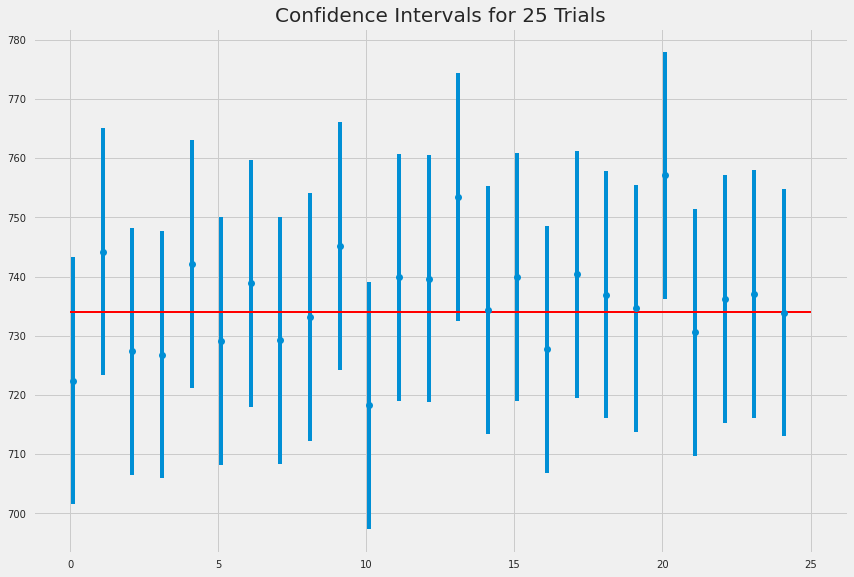

In [ ]:
random.seed(10)
sample_size = 1000
intervals = [] # Empty list
sample_means = []

for sample in range(25):
    sample = random.choice(a= df['MPX'], 
                           size = sample_size,)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)
    z_critical = norm.ppf(q = 0.975)
    pop_stdev = df['MPX'].std()
    norm.ppf(q = 0.025)
    margin_of_error = z_critical * (pop_stdev/sqrt(sample_size))
    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)  
    
    intervals.append(confidence_interval)
    
plt.figure(figsize=(13, 9))
plt.errorbar(x=arange(0.1, 25, 1), 
             y=sample_means, 
             yerr=[(top-bott)/2 for top, bott in intervals],
             fmt='o',)

plt.hlines(xmin=0,
           xmax=25,
           y=df['MPX'].mean(), 
           linewidth=2.0,
           color="red",)

plt.title('Confidence Intervals for 25 Trials',
          fontsize = 20,)
plt.show()

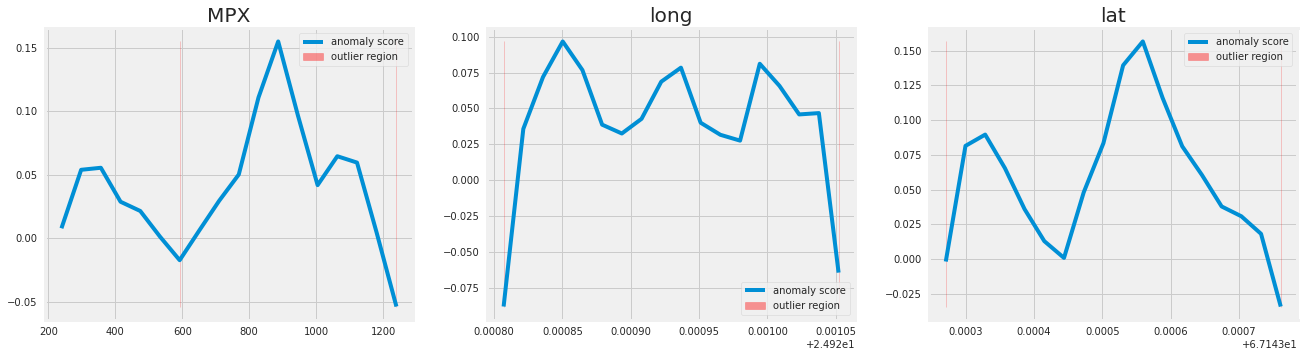

In [ ]:
cols = df
fig, axs = plt.subplots(1,
                        3,
                        figsize=(20, 5),)
fig.set_facecolor('w')
fig.set_edgecolor('k')
axs = axs.reshape(-1) # Return a 1D array

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.1) # Outlier thresh
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1)) # 2D array

    xx = linspace(df[column].min(), # Starting value of the sequence
                  df[column].max(), # End value of the sequence
                  len(df), # No. of samples to generate
                  endpoint=True,).reshape(-1, 1) # End value = Last sample
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',)
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score), # Minimum boundary
                        max(anomaly_score), # Maximum boundary
                        where=outlier==-1, # Threshold to fill in a curve
                        color='r', # Fill color
                        alpha=.4, # See overlapped shaded regions
                        label='outlier region',)
    axs[i].legend(frameon=True) # Show box enclosing the legend text
    axs[i].set_title(column)

In [ ]:
any(df.long <= 0)

False

In [ ]:
any(df.lat <= 0)

False

In [ ]:
any(df.MPX <= 0)

False

In [ ]:
# Define predictor (X) and target variables (y)
X = df[['long',
        'lat',]]

y = df['MPX'].to_numpy().reshape(-1, 1)

In [ ]:
imp = KNNImputer(missing_values=nan, # Missing values marked as nan
                 n_neighbors=5, # No. of near values
                 weights='distance', # Nearest value = Greatest influence
                 metric='nan_euclidean',)

In [ ]:
regr = CatBoostRegressor(n_estimators=4000)

In [ ]:
pipeline = make_pipeline(imp, regr)
pipeline.fit(X, y.reshape(-1),)

Learning rate set to 0.006657
0:	learn: 326.8053165	total: 46.1ms	remaining: 3m 4s
1:	learn: 325.7733010	total: 46.5ms	remaining: 1m 33s
2:	learn: 324.9418156	total: 46.9ms	remaining: 1m 2s
3:	learn: 324.2301396	total: 47.2ms	remaining: 47.2s
4:	learn: 323.5576257	total: 47.5ms	remaining: 38s
5:	learn: 322.6212966	total: 47.8ms	remaining: 31.8s
6:	learn: 321.7122370	total: 48.1ms	remaining: 27.4s
7:	learn: 320.8720992	total: 48.4ms	remaining: 24.2s
8:	learn: 320.3212679	total: 48.8ms	remaining: 21.6s
9:	learn: 319.6413870	total: 49.1ms	remaining: 19.6s
10:	learn: 318.7921446	total: 49.3ms	remaining: 17.9s
11:	learn: 318.1571851	total: 49.6ms	remaining: 16.5s
12:	learn: 317.3730772	total: 49.9ms	remaining: 15.3s
13:	learn: 316.5844347	total: 50.2ms	remaining: 14.3s
14:	learn: 315.9249458	total: 50.5ms	remaining: 13.4s
15:	learn: 315.4961357	total: 51ms	remaining: 12.7s
16:	learn: 314.8943611	total: 51.3ms	remaining: 12s
17:	learn: 313.8925997	total: 51.5ms	remaining: 11.4s
18:	learn: 31

Pipeline(memory=None,
         steps=[('knnimputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='distance')),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x7fc932b18da0>)],
         verbose=False)

In [ ]:
dump(pipeline, 'pipeline.joblib') # Save pipeline file on your device

['pipeline.joblib']

In [ ]:
scores = cross_val_score(pipeline,
                         X, y.reshape(-1),
                         cv=18, # 18-fold split
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1,) # Use every CPU core
print(scores)

[-327.04862992 -154.69091026 -226.71030257  -88.90211388 -113.80776819
 -426.72883063  -80.74790534 -156.10223819 -181.29869997  -38.39520614
 -266.93716154 -147.92181056  -25.59883462 -114.76814514  -52.40629548
  -88.82126286  -87.6666879   -75.13823018]


In [ ]:
mean_scores = (-1 * scores.mean())
print('RMSE: {:.4f}'.format(mean_scores))

RMSE: 147.4273
